In [22]:
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_anat, plot_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import mean_img
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'src', 'glm'))
from brain_regions import find_brain_regions

## Creation of the Design Matrice

<Figure size 1200x600 with 0 Axes>

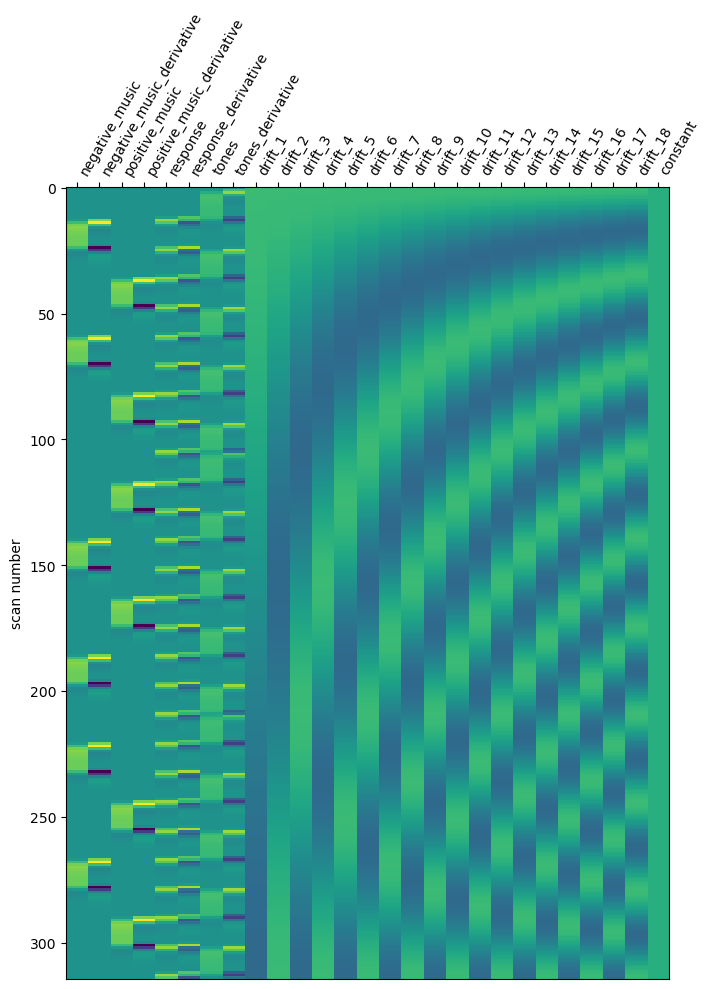

In [23]:
# Define paths
base_dir = os.path.join("..","data","raw", "sub-control01") 
preprocess_dir = os.path.join("..", "data", "preprocessed", "sub-control01")
figures_dir = os.path.join("..", "results", "figures", "glm")
glm_result_dir = os.path.join("..", "results", "glm")

# Load the event files for each run
events = [
    pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-1_events.tsv"), sep="\t"),
    pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-2_events.tsv"), sep="\t"),
    pd.read_csv(os.path.join(base_dir, "func", "sub-control01_task-music_run-3_events.tsv"), sep="\t")
]

# Load the functional image to extract TR and run durations
img = nib.load(os.path.join(base_dir, "func", "sub-control01_task-music_run-1_bold.nii.gz"))
img_to_fit = nib.load(os.path.join(preprocess_dir,"func", "preprocessed_data.nii.gz"))
TR = img.header.get_zooms()[3].item()
run_durations = [events[i]['onset'].iloc[-1] + events[i]['duration'].iloc[-1] for i in range(3)]

# Adjust onsets based on cumulative duration of previous runs
events[1]['onset'] += run_durations[0]
events[2]['onset'] += run_durations[0] + run_durations[1]

# Concatenate the events into a single DataFrame
all_events = pd.concat(events, ignore_index=True)

# Perform the GLM analysis
fmri_glm = FirstLevelModel(t_r=TR, hrf_model='spm + derivative', standardize=False)
fmri_glm = fmri_glm.fit(img_to_fit, events=all_events)
design_matrix = fmri_glm.design_matrices_[0]

# Plot and save the design matrix
plt.figure(figsize=(12, 6))
plot_design_matrix(design_matrix)
plt.savefig(os.path.join(figures_dir, "design_matrix_glm_analysis.png"))


## Initial Statistical Analysis Using an Arbitrary Z-Threshold

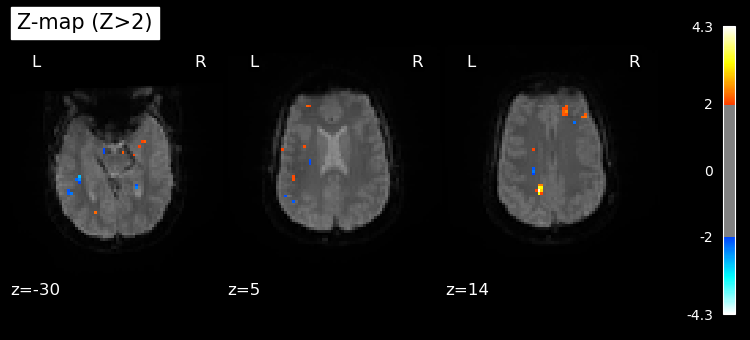

In [24]:
# Beta maps and z-maps of each of our regressors 
regressors = ['negative_music', 'positive_music', 'response', 'tones'] # We select the regressors of interest
for regressor in regressors:
    # Create a contrast vector with a 1 for the current regressor and 0 for others
    contrast = np.zeros(len(design_matrix.columns))
    contrast[design_matrix.columns.get_loc(regressor)] = 1

    # Compute beta map and z-map for this contrast
    beta_map = fmri_glm.compute_contrast(contrast, output_type='effect_size')
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

    # Save the beta map and the z-map
    beta_map.to_filename(os.path.join(glm_result_dir, f"beta_map_{regressor}.nii.gz"))
    z_map.to_filename(os.path.join(glm_result_dir, f"z_map_{regressor}.nii.gz"))
        
    
# Compute the contrast
_mean_img = mean_img(img)
contrast = np.eye(design_matrix.shape[1])[0] - np.eye(design_matrix.shape[1])[1]
z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

# Plot and save the Z-map
plot_stat_map(z_map, bg_img=_mean_img, threshold=2, display_mode='z', cut_coords=[-30, 5, 14], black_bg=True, title='Z-map (Z>2)')
plt.savefig(os.path.join(figures_dir, "z_map.png"))


## Reliable Statistical Inference Using FPR Analysis

Max z-score: 4.331468142927579 at voxel coordinates: (np.int64(45), np.int64(39), np.int64(34))
Maximal contrast region: Amygdala_L at coordinates (-7.929708272218704, -59.26570202410221, 13.999559082090855)


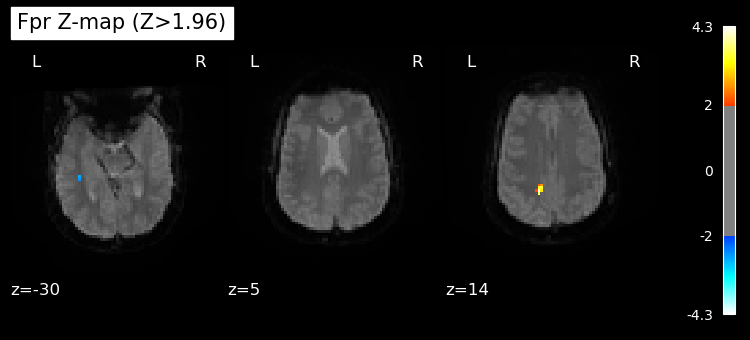

In [26]:
# Apply FPR correction and save the thresholded map
cluster_size = 10
thresholded_map, threshold = threshold_stats_img(z_map, alpha=0.05, height_control='fpr', cluster_threshold=cluster_size)
thresholded_map.to_filename(os.path.join(glm_result_dir, "fdr_thresholded_map.nii.gz"))
_mean_img.to_filename(os.path.join(glm_result_dir, "mean_img.nii.gz"))
plot_stat_map(thresholded_map, bg_img=_mean_img, threshold=threshold, display_mode='z', cut_coords=[-30, 5, 14], black_bg=True, title=f"Fpr Z-map (Z>{round(threshold, 2)})")
plot_stat_map(thresholded_map, bg_img=_mean_img, threshold=threshold, display_mode='z', cut_coords=[-30, 5, 14], black_bg=True, title=f"Fpr Z-map (Z>{round(threshold, 2)})")
plt.savefig(os.path.join(figures_dir, "fpr_z_map.png"))
plt.close()

# Find the brain region with the maximum z-score in the thresholded map
find_brain_regions(thresholded_map)
